# 3.0 Prompting

This notebook:
- Initializes the Flan-T5-small model and tokenizer for text generation.
- Implements zero-shot prompting — model classifies reviews without seeing examples.
- Implements few-shot prompting — model is given 4 labeled examples (2 positive, 2 negative) before classification.
- Evaluates model predictions using:
    - Accuracy, Macro F1, and Brier Score
    - Confusion matrices and reliability (calibration) curves

In [ ]:
import json
from pathlib import Path
import yaml
import random
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, brier_score_loss, classification_report
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import joblib
import csv

In [48]:
ROOT = Path.cwd().parent
CFG_PATH = ROOT / "configs" / "data.yaml"

with open(CFG_PATH, "r") as f:
    CFG = yaml.safe_load(f)

DIR_SPLITS = ROOT / CFG.get("output_splits", "data/splits")
DIR_TABLES = ROOT / CFG["output_tables"]
DIR_FIGS   = ROOT / CFG["output_figures"]
DIR_PREDS  = ROOT / CFG["output_preds"]
DIR_MODELS = ROOT / CFG["output_models"]

for p in (DIR_TABLES, DIR_FIGS, DIR_PREDS, DIR_MODELS, DIR_SPLITS):
    p.mkdir(parents=True, exist_ok=True)


In [49]:
seed = CFG.get("seed", 20)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(torch.cuda.get_device_name(0))

# Load the two datasets
dataset_imdb = CFG.get("dataset_imdb", "imdb")
dataset_rt   = CFG.get("dataset_rotten_tomatoes", "rotten_tomatoes")

ds_imdb = load_dataset(dataset_imdb)
ds_rt   = load_dataset(dataset_rt)

# Load indices created from the first notebook
with open(DIR_SPLITS / "imdb_indices.json") as f:
    imdb_splits = json.load(f)

with open(DIR_SPLITS / "rt_indices.json") as f:
    rt_splits = json.load(f)

# Concatenate full datasets to allow global indexing
ds_imdb_full = concatenate_datasets([ds_imdb["train"], ds_imdb["test"]])
ds_rt_full   = concatenate_datasets([ds_rt["train"], ds_rt["validation"], ds_rt["test"]])

# Function to select rows based on indices
def select_rows(ds, indices, text_key="text", label_key="label"):
    data = [ds[i] for i in indices]
    return pd.DataFrame({
        "text": [d[text_key] for d in data],
        "label": [d[label_key] for d in data]
    })

# Only get test splits since we are only using test splits for prompting
imdb_test = select_rows(ds_imdb_full, imdb_splits["test"])
rt_test   = select_rows(ds_rt_full, rt_splits["test"])

print("IMDB test size:", len(imdb_test))
print("RT test size:", len(rt_test))


Using device: cuda
NVIDIA GeForce RTX 3050 Ti Laptop GPU
IMDB test size: 5000
RT test size: 1067


In [ ]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on " + device)
model.to(device)
seed = 45

task_prefix = "Classify the sentiment of this review as Positive or Negative:\n\n"

def zero_shot_predict(texts, max_length=30):
    preds = []
    for text in texts:
        prompt = task_prefix + f"Review: {text}\nSentiment:"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=max_length)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        label = decoded.strip().split()[0].lower().rstrip(".!,")
        preds.append(1 if "positive" in label else 0)
    return preds

def few_shot_predict(texts, examples, max_length=30):
    preds = []
    prefix = task_prefix
    for ex_text, ex_label in examples:
        prefix += f"Review: {ex_text}\nSentiment: {ex_label}\n\n"
    
    for text in texts:
        prompt = prefix + f"Review: {text}\nSentiment:"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=max_length)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        label = decoded.strip().split()[0]
        preds.append(1 if "positive" in label.lower() else 0)
    return preds

short_examples_2 = [
    ("Loved it! Amazing acting.", "Positive"),
    ("Terrible movie. Waste of time.", "Negative")
]

short_examples_4 = [
    ("Loved it! Amazing acting.", "Positive"),
    ("Heartwarming story, well done.", "Positive"),
    ("Terrible movie. Waste of time.", "Negative"),
    ("Awful plot and bad acting.", "Negative")
]

short_examples_6 = [
    ("Loved it! Amazing acting.", "Positive"),
    ("Heartwarming story, well done.", "Positive"),
    ("A brilliant, exciting film.", "Positive"),
    ("Terrible movie. Waste of time.", "Negative"),
    ("Awful plot and bad acting.", "Negative"),
    ("Uninspired and boring.", "Negative")
]

# Long examples
long_examples_2 = [
    ("Loved it! Amazing acting. The story was engaging from start to finish.", "Positive"),
    ("Terrible movie. Waste of time. The plot made no sense at all.", "Negative")
]

long_examples_4 = [
    ("Loved it! Amazing acting. The story was engaging from start to finish.", "Positive"),
    ("Heartwarming story, well done. Characters felt real and relatable.", "Positive"),
    ("Terrible movie. Waste of time. The plot made no sense at all.", "Negative"),
    ("Awful plot and bad acting. I couldn't finish it.", "Negative")
]

long_examples_6 = [
    ("Loved it! Amazing acting. The story was engaging from start to finish.", "Positive"),
    ("Heartwarming story, well done. Characters felt real and relatable.", "Positive"),
    ("A brilliant, exciting film. Every scene kept me on the edge of my seat.", "Positive"),
    ("Terrible movie. Waste of time. The plot made no sense at all.", "Negative"),
    ("Awful plot and bad acting. I couldn't finish it.", "Negative"),
    ("Uninspired and boring. Dialogue was awkward and forced.", "Negative")
]

example_sets = {
    "2_short": short_examples_2,
    "4_short": short_examples_4,
    "6_short": short_examples_6,
    "2_long": long_examples_2,
    "4_long": long_examples_4,
    "6_long": long_examples_6
}

# Sampled test sets for faster computation
sample_size = 100
np.random.seed(seed)

imdb_sample = imdb_test.sample(n=sample_size, random_state=seed)
imdb_texts_sample = imdb_sample["text"].tolist()
imdb_labels_sample = imdb_sample["label"].tolist()

rt_sample = rt_test.sample(n=sample_size, random_state=seed)
rt_texts_sample = rt_sample["text"].tolist()
rt_labels_sample = rt_sample["label"].tolist()

datasets = {
    "IMDB": (imdb_texts_sample, imdb_labels_sample),
    "Rotten Tomatoes": (rt_texts_sample, rt_labels_sample)
}

results_list = []

for ex_name, examples in example_sets.items():
    num_examples = len(examples)
    print(f"\nFew-Shot using {ex_name} examples ({num_examples} examples):")

    for dataset_name, (texts, labels) in datasets.items():
        preds = few_shot_predict(texts, examples)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="macro")
        brier = brier_score_loss(labels, preds)
        print(f"\n{dataset_name} Test Metrics:")
        print(f"Accuracy={acc:.3f}, Macro F1={f1:.3f}, Brier Score={brier:.3f}")

        results_list.append({
            "example_set": ex_name,
            "dataset": dataset_name,
            "accuracy": acc,
            "macro_f1": f1,
            "brier_score": brier
        })


results_df = pd.DataFrame(results_list)
csv_path = DIR_TABLES / "few_shot_ablation_results.csv"
results_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")


Running on cuda

Few-Shot using 2_short examples (2 examples):


Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors



IMDB Test Metrics:
Accuracy=0.940, Macro F1=0.938, Brier Score=0.060

Rotten Tomatoes Test Metrics:
Accuracy=0.760, Macro F1=0.758, Brier Score=0.240

Few-Shot using 4_short examples (4 examples):

IMDB Test Metrics:
Accuracy=0.960, Macro F1=0.959, Brier Score=0.040

Rotten Tomatoes Test Metrics:
Accuracy=0.830, Macro F1=0.830, Brier Score=0.170

Few-Shot using 6_short examples (6 examples):

IMDB Test Metrics:
Accuracy=0.970, Macro F1=0.969, Brier Score=0.030

Rotten Tomatoes Test Metrics:
Accuracy=0.830, Macro F1=0.830, Brier Score=0.170

Few-Shot using 2_long examples (2 examples):

IMDB Test Metrics:
Accuracy=0.950, Macro F1=0.949, Brier Score=0.050

Rotten Tomatoes Test Metrics:
Accuracy=0.770, Macro F1=0.769, Brier Score=0.230

Few-Shot using 4_long examples (4 examples):

IMDB Test Metrics:
Accuracy=0.970, Macro F1=0.969, Brier Score=0.030

Rotten Tomatoes Test Metrics:
Accuracy=0.800, Macro F1=0.800, Brier Score=0.200

Few-Shot using 6_long examples (6 examples):

IMDB Test Me

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on " + device)
model.to(device)

# Based on ablation study, giving 4 examples in few shot gives the best results, so we use 4 balanced examples in the final few-shot prompting model
# done on full test sets
imdb_texts = imdb_test["text"].tolist()

imdb_zs_preds = zero_shot_predict(imdb_texts)
imdb_fs_preds = few_shot_predict(imdb_texts, long_examples_4)

rt_texts = rt_test["text"].tolist()

rt_zs_preds = zero_shot_predict(rt_texts)
rt_fs_preds = few_shot_predict(rt_texts, short_examples_4)


Running on cuda



Zero-Shot Flan-T5 metrics (IMDB):
Accuracy: 0.925, Macro F1: 0.925, Brier Score: 0.075
              precision    recall  f1-score   support

    Negative       0.91      0.94      0.93      2500
    Positive       0.94      0.91      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg       0.93      0.92      0.92      5000



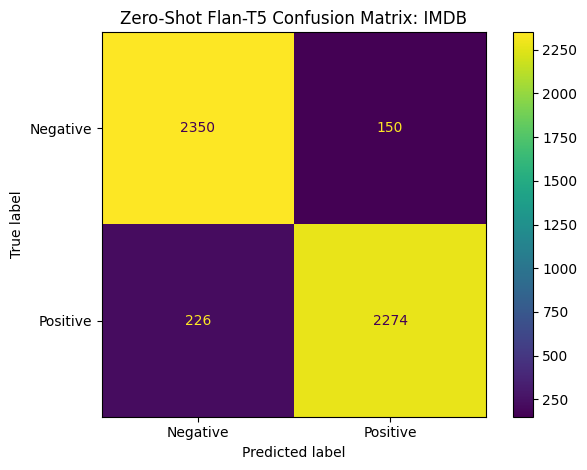

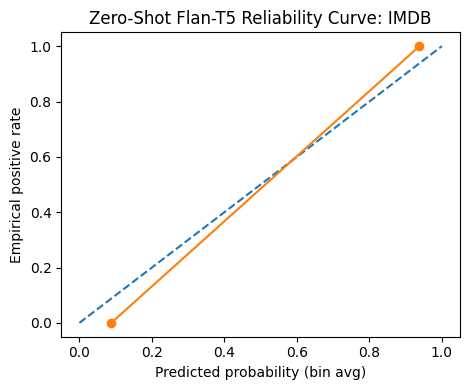


Few-Shot Flan-T5 metrics (IMDB):
Accuracy: 0.921, Macro F1: 0.921, Brier Score: 0.079
              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92      2500
    Positive       0.93      0.91      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



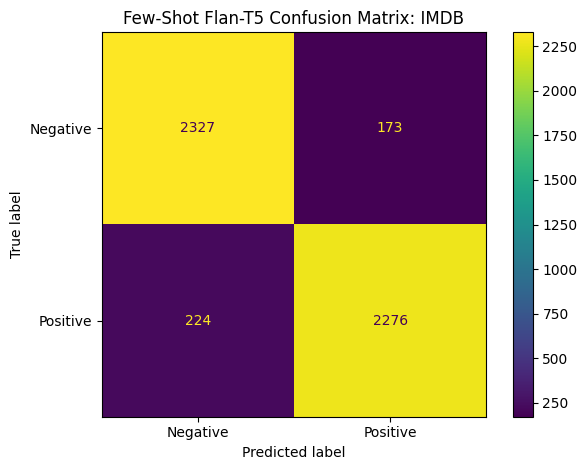

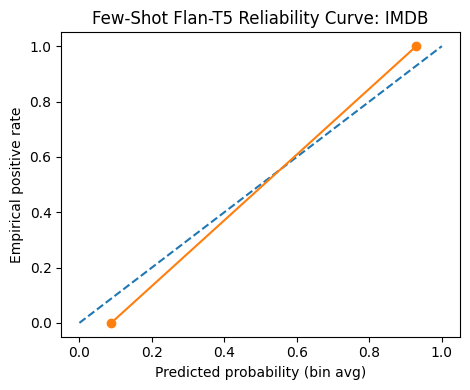


Zero-Shot Flan-T5 metrics (Rotten Tomatoes):
Accuracy: 0.832, Macro F1: 0.832, Brier Score: 0.168
              precision    recall  f1-score   support

    Negative       0.83      0.84      0.83       534
    Positive       0.84      0.82      0.83       533

    accuracy                           0.83      1067
   macro avg       0.83      0.83      0.83      1067
weighted avg       0.83      0.83      0.83      1067



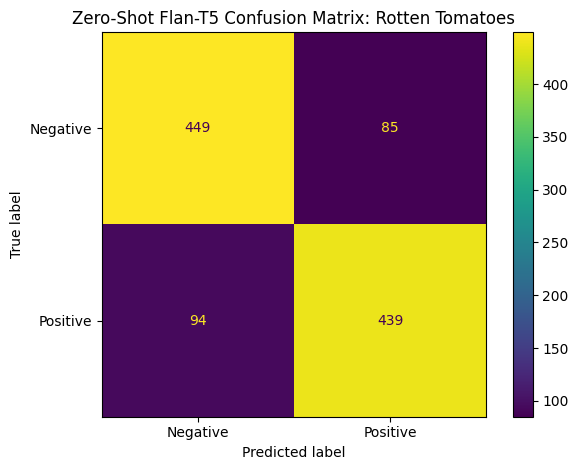

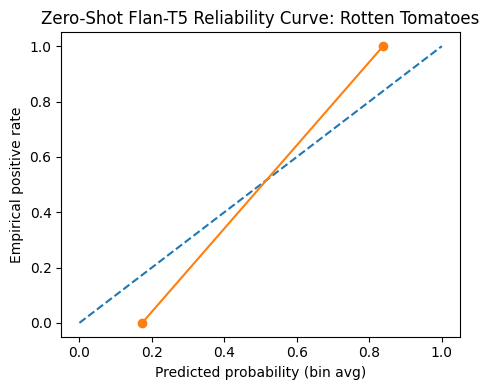


Few-Shot Flan-T5 metrics (Rotten Tomatoes):
Accuracy: 0.846, Macro F1: 0.846, Brier Score: 0.154
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85       534
    Positive       0.85      0.84      0.84       533

    accuracy                           0.85      1067
   macro avg       0.85      0.85      0.85      1067
weighted avg       0.85      0.85      0.85      1067



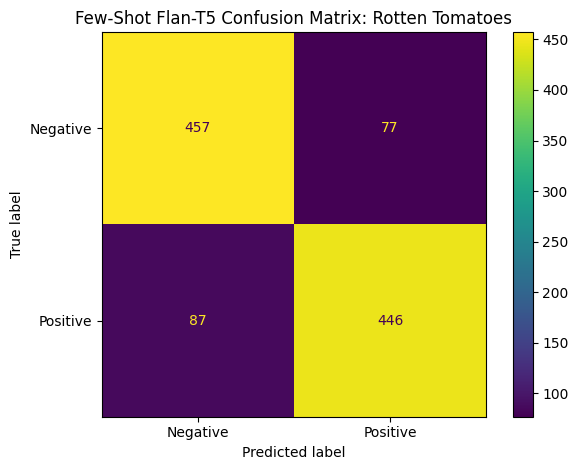

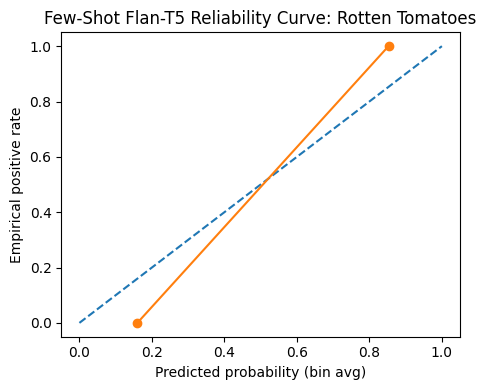

[{'dataset': 'Rotten Tomatoes',
  'model_name': 'Zero-Shot Flan-T5',
  'acc': 0.8322399250234301,
  'macro_f1': 0.832225188402207,
  'brier': 0.16776007497656983,
  'n_test': 1067},
 {'dataset': 'Rotten Tomatoes',
  'model_name': 'Few-Shot Flan-T5',
  'acc': 0.8462980318650422,
  'macro_f1': 0.8462816944959801,
  'brier': 0.15370196813495782,
  'n_test': 1067}]

In [77]:
def evaluate_and_plot(true_labels, zs_preds, fs_preds, texts, dataset_name="Dataset"):
    """
    true_labels: list of integers 0 (Negative) / 1 (Positive)
    zs_preds/fs_preds: list of integers 0/1
    texts: list of the actual review texts (for JSONL output)
    """
    results = []

    def compute_metrics(name, preds):
        pred_bin = preds
        prob_pos = [float(p) for p in preds]  # 1.0 if Positive, 0.0 if Negative

        acc = accuracy_score(true_labels, pred_bin)
        f1m = f1_score(true_labels, pred_bin, average="macro")
        brier = brier_score_loss(true_labels, prob_pos)

        print(f"\n{name} metrics ({dataset_name}):")
        print(f"Accuracy: {acc:.3f}, Macro F1: {f1m:.3f}, Brier Score: {brier:.3f}")
        print(classification_report(true_labels, pred_bin, target_names=["Negative","Positive"]))

        # Save JSONL predictions (with actual review text)
        rows = [{"text": t, "label": int(y), "pred": int(h), "prob_pos": float(p)}
                for t, y, h, p in zip(texts, true_labels, pred_bin, prob_pos)]
        out_path = DIR_PREDS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_test.jsonl"
        with open(out_path, "w", encoding="utf-8") as f:
            for r in rows:
                f.write(json.dumps(r, ensure_ascii=False) + "\n")

        # Confusion matrix
        cm = confusion_matrix(true_labels, pred_bin, labels=[0,1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
        disp.plot(values_format="d")
        plt.title(f"{name} Confusion Matrix: {dataset_name}")
        cm_path = DIR_FIGS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_cm.png"
        plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.show()

        # Reliability curve
        fracs, means = calibration_curve(true_labels, prob_pos, n_bins=10, strategy="quantile")
        plt.figure(figsize=(4.8,4))
        plt.plot([0,1],[0,1], linestyle="--")
        plt.plot(fracs, means, marker="o")
        plt.xlabel("Predicted probability (bin avg)")
        plt.ylabel("Empirical positive rate")
        plt.title(f"{name} Reliability Curve: {dataset_name}")
        rel_path = DIR_FIGS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_reliability.png"
        plt.tight_layout(); plt.savefig(rel_path, dpi=150); plt.show()

        # Append to results summary
        results.append({
            "dataset": dataset_name,
            "model_name": name,
            "acc": acc,
            "macro_f1": f1m,
            "brier": brier,
            "n_test": len(true_labels),
        })

    # Compute metrics for both zero-shot and few-shot
    compute_metrics("Zero-Shot Flan-T5", zs_preds)
    compute_metrics("Few-Shot Flan-T5", fs_preds)

    # Save/append to combined CSV summary
    csv_path = DIR_TABLES / "prompting_metrics.csv"
    file_exists = csv_path.exists()
    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["dataset", "model_name", "acc", "macro_f1", "brier", "n_test"])
        if not file_exists:
            writer.writeheader()
        writer.writerows(results)

    return results




# IMDB
imdb_true_labels = imdb_test["label"].tolist()
evaluate_and_plot(imdb_true_labels, imdb_zs_preds, imdb_fs_preds, texts=imdb_test["text"].tolist(), dataset_name="IMDB")

# Rotten Tomatoes
rt_true_labels = rt_test["label"].tolist()
evaluate_and_plot(rt_true_labels, rt_zs_preds, rt_fs_preds, texts=rt_test["text"].tolist(), dataset_name="Rotten Tomatoes")
